<a href="https://colab.research.google.com/github/Dabaiee/CS5100group7/blob/zixuan/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
filepath = 'https://raw.githubusercontent.com/Dabaiee/CS5100group7/main/ETH-USD.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [3]:
data.shape

(1833, 7)

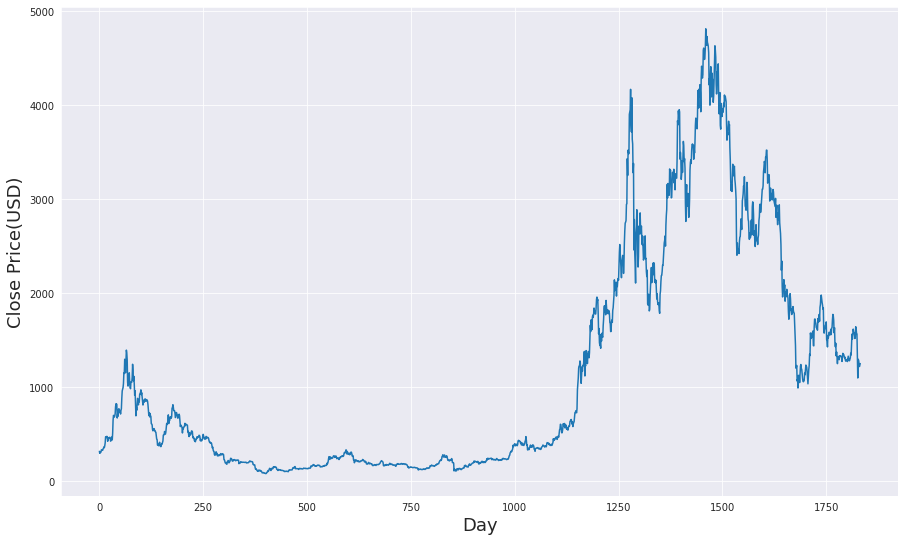

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.figure(figsize = (15, 9))
plt.plot(data['Adj Close'])
# plt.xticks(range(0, data.shape[0], 20), data['Date'].loc[::20], rotation = 45)
# plt.title('Stock Price', fontsize = 30, fontweight = 'blod')
plt.xlabel('Day', fontsize = 18)
plt.ylabel('Close Price(USD)', fontsize = 18)
plt.show()

In [5]:
# 收盘价
price = data[['Close']]
price.info

<bound method DataFrame.info of             Close
0      320.884003
1      299.252991
2      314.681000
3      307.907990
4      316.716003
...           ...
1828  1287.221069
1829  1255.268311
1830  1221.819214
1831  1241.604248
1832  1253.259399

[1833 rows x 1 columns]>

In [6]:
from sklearn.preprocessing import MinMaxScaler
# 缩放 特点1.为了各个特征对于结果，影响的权重是一样的 2.避免在训练的过程中，导致梯度过度消失或过度爆炸
scaler = MinMaxScaler(feature_range = (-1, 1)) 
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
price['Close'].shape

(1833,)

In [8]:
def split_data(stock, lookback): #lookback: 观察（lookback）的天数的数据来预测明天的收盘价
  data_raw = stock.to_numpy() # 收盘价的序列 1833
  print(data_raw)
  data = []

  for index in range(len(data_raw) - lookback):
    data.append(data_raw[index: index + lookback])

  data = np.array(data)
  test_set_size = int(np.round(0.2 * data.shape[0]))
  train_set_size = data.shape[0] - (test_set_size)

  x_train = data[:train_set_size, :-1, :]  # [8,9,10] :-1意思是8 & 9 作为输入x_train, 10作为标签
  y_train = data[:train_set_size, -1, :]

  x_test = data[train_set_size:, :-1]
  y_test = data[train_set_size:, -1, :]

  return [x_train, y_train, x_test, y_test]


In [9]:
lookback = 20 # 通过 x:19 -> y:1
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)


[[-0.899921  ]
 [-0.9090716 ]
 [-0.90254506]
 ...
 [-0.51879693]
 [-0.51042723]
 [-0.50549673]]
x_train.shape = (1450, 19, 1)
y_train.shape = (1450, 1)
x_test.shape = (363, 19, 1)
y_test.shape = (363, 1)


In [10]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor) #数据转化的过程 从numpy 转化到 torch
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)


In [11]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100 # 100个迭代次数

In [12]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True) # (N,L,H)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :])
    return out


In [13]:
model = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim= output_dim, num_layers= num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)

In [14]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
  y_train_pred = model(x_train)

  loss = criterion(y_train_pred, y_train_lstm)
  print("Epoch", t, "MSE", loss.item())
  hist[t] = loss.item()

  optimiser.zero_grad()
  loss.backward()
  optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch 0 MSE 0.5327989459037781
Epoch 1 MSE 0.36841392517089844
Epoch 2 MSE 0.21850882470607758
Epoch 3 MSE 0.19102813303470612
Epoch 4 MSE 0.18008694052696228
Epoch 5 MSE 0.1475672870874405
Epoch 6 MSE 0.148795485496521
Epoch 7 MSE 0.14744441211223602
Epoch 8 MSE 0.13131754100322723
Epoch 9 MSE 0.1057727038860321
Epoch 10 MSE 0.09358187764883041
Epoch 11 MSE 0.09824291616678238
Epoch 12 MSE 0.07023318856954575
Epoch 13 MSE 0.05408589169383049
Epoch 14 MSE 0.05559141933917999
Epoch 15 MSE 0.04032072052359581
Epoch 16 MSE 0.02252608723938465
Epoch 17 MSE 0.030824024230241776
Epoch 18 MSE 0.021831173449754715
Epoch 19 MSE 0.019865773618221283
Epoch 20 MSE 0.028935246169567108
Epoch 21 MSE 0.022244341671466827
Epoch 22 MSE 0.014327012002468109
Epoch 23 MSE 0.011540671810507774
Epoch 24 MSE 0.010415546596050262
Epoch 25 MSE 0.009267257526516914
Epoch 26 MSE 0.009018946439027786
Epoch 27 MSE 0.009918889962136745
Epoch 28 MSE 0.010798842646181583
Epoch 29 MSE 0.010540731251239777
Epoch 30 MSE

In [15]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

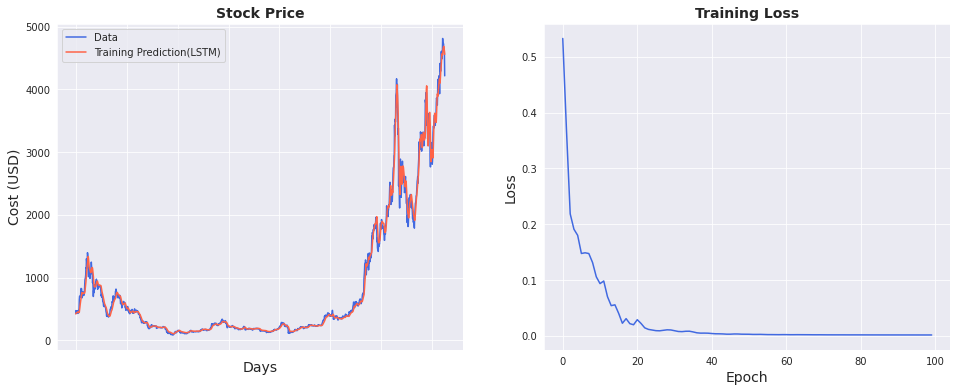

In [16]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace = 0.2, wspace = 0.2)

plt.subplot(1,2,1)
ax = sns.lineplot(x = original.index, y = original[0], label = 'Data', color = 'royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label = 'Training Prediction(LSTM)', color = 'tomato')
ax.set_title('Stock Price', size =14, fontweight = 'bold')
ax.set_xlabel('Days', size = 14)
ax.set_ylabel('Cost (USD)', size = 14)
ax.set_xticklabels('', size = 10)

plt.subplot(1,2,2)
ax = sns.lineplot(data = hist, color = 'royalblue')

ax.set_title('Training Loss', size =14, fontweight = 'bold')
ax.set_xlabel('Epoch', size = 14)
ax.set_ylabel('Loss', size = 14)
fig.set_figheight(6)
fig.set_figwidth(16)



In [17]:
x_test[-1]

tensor([[-0.3730],
        [-0.3950],
        [-0.3776],
        [-0.3505],
        [-0.3627],
        [-0.3704],
        [-0.3674],
        [-0.3928],
        [-0.3878],
        [-0.3397],
        [-0.3470],
        [-0.3706],
        [-0.3721],
        [-0.4718],
        [-0.5703],
        [-0.4860],
        [-0.4911],
        [-0.5046],
        [-0.5188]])

In [18]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

#invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0],y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0],y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)


Train Score: 93.02 RMSE
Test Score: 158.99 RMSE


In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred) + lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + lookback -1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis = 1)
predictions = np.append(predictions, original, axis = 1)
result = pd.DataFrame(predictions)



In [23]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x = result.index, y = result[0],mode = 'lines', name = 'Train prediction')))
fig.add_trace(go.Scatter(x = result.index, y = result[1],mode = 'lines', name = 'Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x = result.index, y = result[2],mode = 'lines', name = 'Actual Value')))
fig.update_layout(
    xaxis = dict(
        showline = True, showgrid= True, showticklabels=False, 
        linecolor = 'white', linewidth=2
    ),
    yaxis=dict(title_text='Close(USD)',
        titlefont = dict(
            family='Rockwell', size = 12, color='white',
        ),
        showline=True, showgrid=True,showticklabels=True,
        linecolor='white', linewidth=2, ticks='outside',
        tickfont=dict(
            family='Rockwell', size=12, color='white',
        ),
    ),
    showlegend = True,
    template = 'plotly_dark'
)

annotations = []
annotations.append(dict(xref = 'paper', yref='paper', x=0.0, y=1.05,
                               xanchor='left', yanchor = 'bottom',
                               text='Result(LSTM)', 
                               font=dict(family = 'Rockwell', size = 26, 
                                         color = 'white'),
                               showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()
